In [61]:
import numpy as np 
import matplotlib.pyplot as plt
import scipy.signal as sp
from scipy.signal import chirp, spectrogram, butter, filtfilt, hilbert, correlate
from scipy.stats import linregress

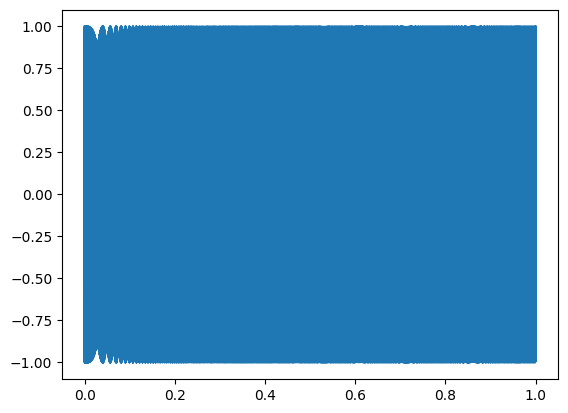

In [62]:
# Parameters
fs = 30e3           # 1 MHz sampling
T = 1           # duration
t = np.linspace(0, T, int(fs * T))

f0 = 5e3       # Start frequency
S1 = 200             # Chirp slope

phi = 2 * np.pi * (f0 * t + 0.5 * S1 * t**2)
signal = np.cos(phi)

plt.plot(t, signal)

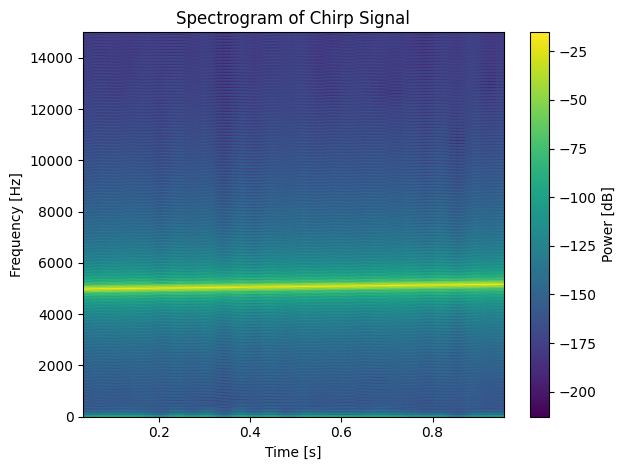

In [63]:
from scipy.signal import spectrogram

f, t_spec, Sxx = spectrogram(signal, fs=fs, nperseg=2048, noverlap=1024)
plt.pcolormesh(t_spec, f, 10 * np.log10(Sxx), shading='gouraud')
plt.title("Spectrogram of Chirp Signal")
plt.ylabel("Frequency [Hz]")
plt.xlabel("Time [s]")
# plt.ylim([0, 75e2])
plt.colorbar(label='Power [dB]')
plt.tight_layout()
plt.show()

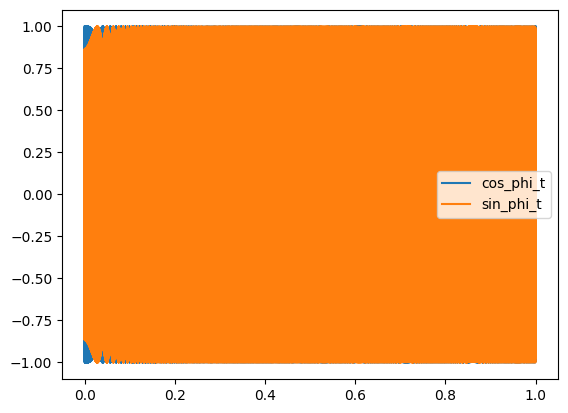

In [64]:
cos_phi_t = np.cos(phi)
sin_phi_t = np.sin(phi)

plt.plot(t, cos_phi_t, label='cos_phi_t')
plt.plot(t, sin_phi_t, label='sin_phi_t')
plt.legend()

In [65]:
# Receiving signal with time differece
d = 105e-3 #m 
c = 3e8 # m/s
dt = d/c
Tc = 72e-6  #s 
tau = T*(dt/Tc)
# tau = 0.1
print(tau)

4.8611111111111105e-06


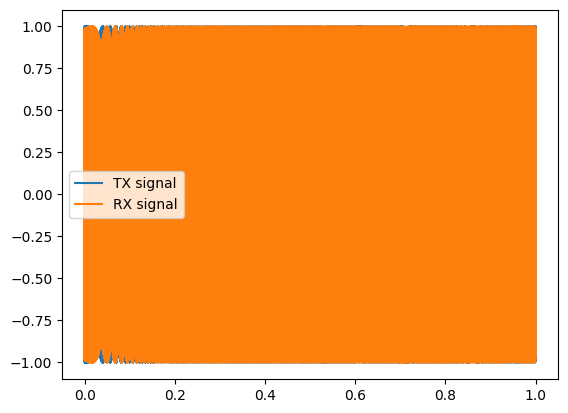

In [66]:
Srx = 150
phi_rx = np.zeros_like(t)
t_delayed = t - tau
valid_indices = t_delayed >= 0
phi_rx[valid_indices] = 2 * np.pi * (f0 * t_delayed[valid_indices] + 0.5 * Srx * t_delayed[valid_indices]**2)
rx_sig = np.cos(phi_rx)
rx_sig[~valid_indices] = 0 

plt.plot(t, signal, label='TX signal')
plt.plot(t, rx_sig, label='RX signal')
plt.legend()


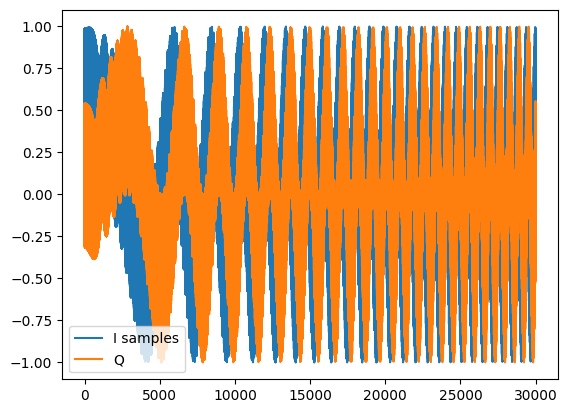

In [67]:
if_samples_i = rx_sig*cos_phi_t
if_samples_q = rx_sig*sin_phi_t

plt.plot(if_samples_i, label='I samples')
plt.plot(if_samples_q, label='Q')
plt.legend()

In [68]:
iq_if_signal = if_samples_i + 1j * if_samples_q

iq_if_signal

array([0.        +0.00000000e+00j, 0.31292867+5.42052935e-01j,
       0.18127519-3.13925191e-01j, ..., 0.38646195+5.55963042e-01j,
       0.15224136-2.91236110e-01j, 0.98765419+8.56104658e-14j])

In [69]:
# Use the resampled version of the IF signal 
from scipy.signal import resample

fs_target = 256
n_target = int(fs_target * T)
t_rs = np.linspace(0, T, n_target)
iq_if_signal = resample(iq_if_signal, n_target)

delta =  1.5765996259384667


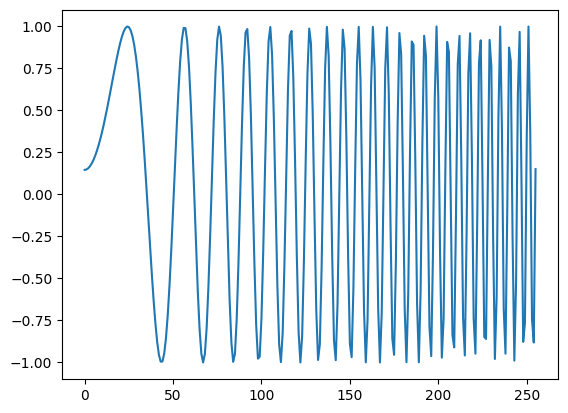

In [70]:
# Here, the template will change too 
np.random.seed(41)
delta = np.random.rand()*2*np.pi  # Generate a random phase shift (due to lack of phase locking)
phi_template = 2*np.pi*( Srx*tau*t_rs + 0.5*(S1-Srx)*t_rs**2 + (f0*tau - 0.5*Srx*tau**2)) - delta
template_sig = np.cos(phi_template) 

print("delta = ", delta)
plt.plot(template_sig)

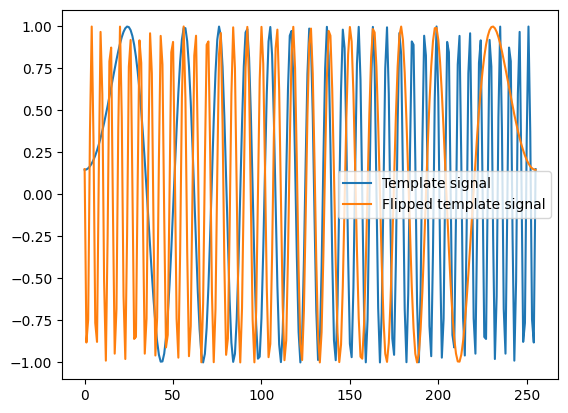

In [71]:
# Check using lfilter 
h = template_sig[::-1]
plt.plot(template_sig, label='Template signal')
plt.plot(h, label='Flipped template signal')
plt.legend()
plt.show()

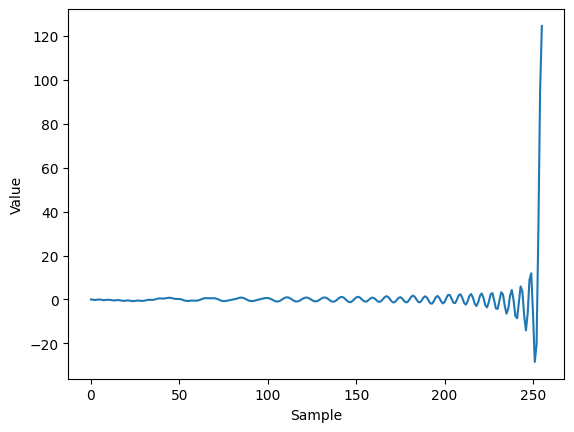

In [72]:
signoisemf = sp.lfilter(h, 1, template_sig)
plt.plot(signoisemf)
plt.xlabel("Sample")
plt.ylabel("Value")
plt.show()

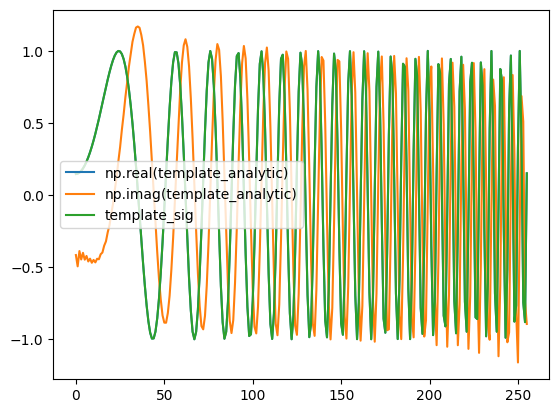

In [73]:
template_analytic = hilbert(template_sig) # Takes the hilbert transform
plt.plot(np.real(template_analytic), label='np.real(template_analytic)')
plt.plot(np.imag(template_analytic), label='np.imag(template_analytic)')
plt.plot(template_sig, label='template_sig')
plt.legend()
plt.show()

#Real and the actual template sig are the exact same 


In [74]:
h_mf = np.conj(template_analytic[::-1])
mf_output = sp.lfilter(h_mf, 1, iq_if_signal)

/home/sohamc1909/miniconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1699: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/sohamc1909/miniconda3/lib/python3.12/site-packages/matplotlib/cbook.py:1345: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


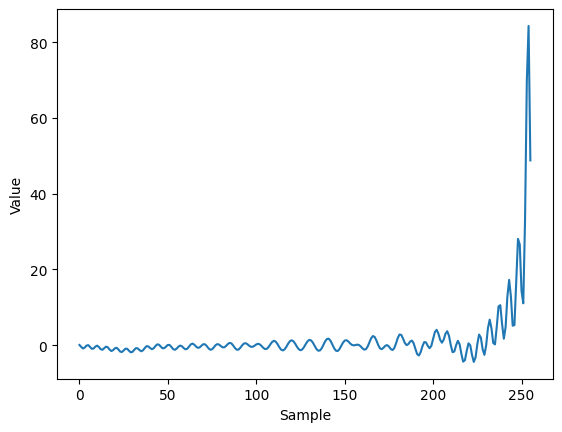

In [75]:
plt.plot(mf_output)
plt.xlabel("Sample")
plt.ylabel("Value")
plt.show()

In [ ]:
deltas = np.linspace(0, 2*np.pi, 500)  #Generate 500 test deltas to check 

mf_output_hmap = np.zeros((len(deltas), n_target))
for idx, delta_x in enumerate(deltas):
    # Checking with templates with different delta
    phi_template = 2*np.pi*( Srx*tau*t_rs + 0.5*(S1-Srx)*t_rs**2 + (f0*tau - 0.5*Srx*tau**2)) - delta_x
    template_sig = np.cos(phi_template) 
    h_mf = np.conj(hilbert(template_sig)[::-1])
    mf_output_hmap[idx] = sp.lfilter(h_mf, 1, iq_if_signal)

/tmp/ipykernel_53114/3100097202.py:9: ComplexWarning: Casting complex values to real discards the imaginary part
  mf_output_hmap[idx] = sp.lfilter(h_mf, 1, iq_if_signal)


<Axes: >

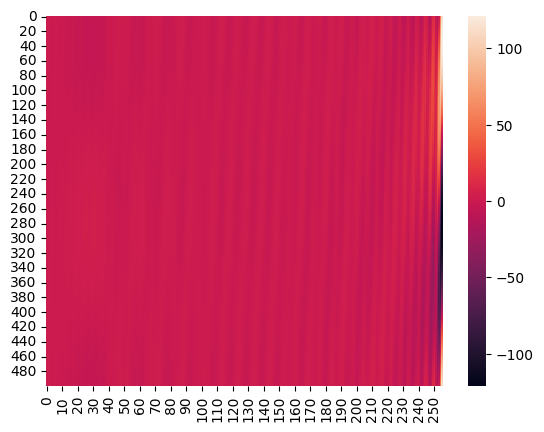

In [83]:
import seaborn as sns 
sns.heatmap(mf_output_hmap)

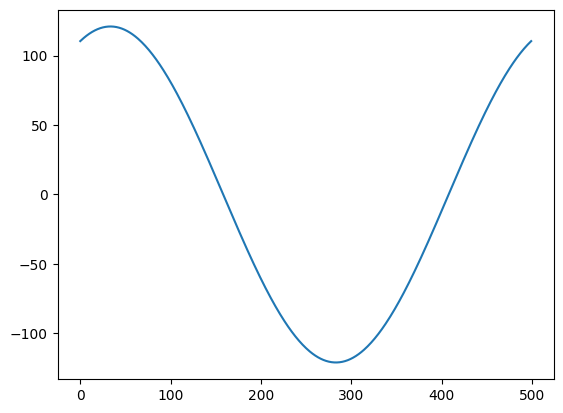

In [82]:
plt.plot(mf_output_hmap[:, -1])

In [91]:
# If the signal was a random one, would we see these find of characteristics
random_signal = 2 * np.random.rand(256) - 1
random_signal = hilbert(random_signal)

In [88]:
random_mf_hmap = np.zeros((len(deltas), n_target))
for idx, delta_x in enumerate(deltas):
    # Checking with templates with different delta
    phi_template = 2*np.pi*( Srx*tau*t_rs + 0.5*(S1-Srx)*t_rs**2 + (f0*tau - 0.5*Srx*tau**2)) - delta_x
    template_sig = np.cos(phi_template) 
    h_mf = np.conj(hilbert(template_sig)[::-1])
    random_mf_hmap[idx] = sp.lfilter(h_mf, 1, random_signal)

/tmp/ipykernel_53114/2077455028.py:7: ComplexWarning: Casting complex values to real discards the imaginary part
  random_mf_hmap[idx] = sp.lfilter(h_mf, 1, random_signal)


<Axes: >

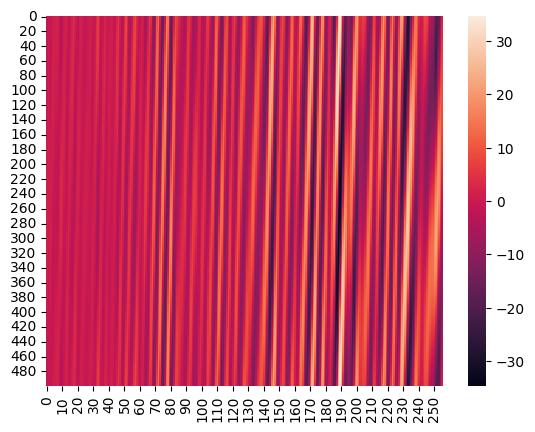

In [89]:
sns.heatmap(random_mf_hmap)

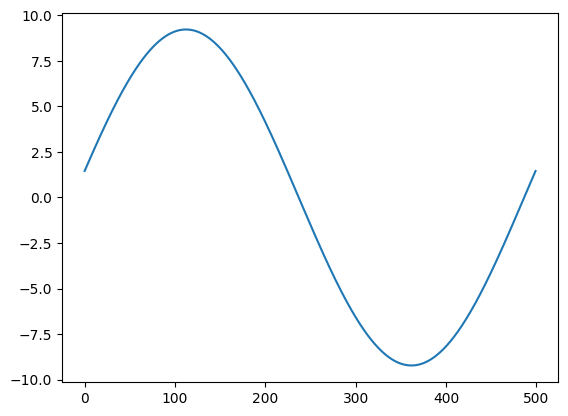

In [90]:
plt.plot(random_mf_hmap[:,-1])